In [ ]:
"""
Conversion from Ana's -> Alex's data
Timestamp -> date
SiteCode -> code
Latitude -> latitude
Longitude -> longitude
transform_data(monthly_NO2_df, pollutant -> pollutant.lower())
"""

In [1]:
from multiprocessing import pool
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
import matplotlib.pyplot as plt
import os
import random
from calendar import monthrange

In [2]:
def load_data(pollutant, data_path="data-collection/", timestep=None, time_range=None, season=None, dayOfWeek=None, timeOfDay=None):
    """
    :param pollutant: {"CO", "NO2", "O3", "SO2", "PM10", "PM25"}
    :param data_path: path to data directory
    :param timestep: {"H", "D", "M", "Y"}
    :param time_range: if provided, get data within the given time_range, inclusive (if second element isn't provided, defaults to today)
    :param season: if provided, {"winter", "spring", "summer", "autumn"} for seasonal buckets
            Winter: December, January, Ferbruary
            Spring: March, April and May
            Summer: June, July and August
            Autumn: September, October and November
    :param dayOfWeek: if provided, {"weekday", "weekend"}
    :param timeOfDay: if provided, {"day", "night"}
    """
    df = pd.read_csv(f"{data_path}{pollutant}.csv", parse_dates=["date"])

    # get data within a given time range
    if time_range:
        start, end = time_range
        if not end:
            end = datetime.today
        df = df.loc[(df["date"] >= start) & (df["date"] <= end)]

    df = df.set_index("date")
    # daily, monthly, yearly
    if timestep in {"D", "M", "Y"}:
        index_format = {"D": "%Y-%m-%d", "M": "%Y-%m", "Y": "%Y"}
        df = df.groupby(by=["code"]).resample(timestep).mean().dropna().reset_index()
        # df["date"] = df["date"].apply(lambda x: x.strftime(index_format[timestep]))

    # seasonal buckets
    if season:
        months = [12, 1, 2] if season == "winter" \
            else [i for i in range(3, 6)] if season == "spring" \
                else [i for i in range(6, 9)] if season == "summer" \
                    else [i for i in range(9, 12)] if season == "autumn" else [i for i in range(12)]

        df["Month"] = pd.DatetimeIndex(df['date']).month
        # print(df)

        # define condition: month must be within seasonal month range
        condition = ((df.Month >= months[0]) & (df.Month <= months[-1]))
        if season == "winter":
            condition = ((df.Month >= months[0]) | (df.Month <= months[-1]))
        df = df.loc[condition]
        
        # print(df)
        # print("Season: ", season, " , ", months)
        # print("Season Months: ", df.Month.unique())

        # drop created month column
        df = df.drop(["Month"], axis=1)
        print(df)
        
    # day of week buckets: weekday vs weekend
    if dayOfWeek:
        days = [i for i in range(5)] if dayOfWeek == "weekday" else [i for i in range(5,7)]

        df["DayOfWeek"] = pd.DatetimeIndex(df['date']).dayofweek

        condition = ((df.DayOfWeek >= days[0]) & (df.DayOfWeek <= days[-1]))
        df = df.loc[condition]

        # print(df)
        # print("Day of week: ", dayOfWeek, " , ", days)
        # print("Day of week days: ", df.DayOfWeek.unique())

        df = df.drop(["DayOfWeek"], axis=1)
    
    # daytime (7am - 5pm) vs nighttime (5pm - 7am) buckets, according to London's sunrise and sunset times
    if timeOfDay:
        hours = [i for i in range(7, 18)] if timeOfDay == "day" else [i%24 for i in range(18, 31)]

        df["Hour"] = pd.DatetimeIndex(df['date']).hour

        condition = ((df.Hour >= hours[0]) & (df.Hour <= hours[-1]))
        if timeOfDay == "night":
            condition = ((df.Hour >= hours[0]) | (df.Hour <= hours[-1]))
        df = df.loc[condition]

        # print(df)
        # print("Time of day: ", timeOfDay, " , ", hours)
        # print("Hours of time of day in df: ", df.Hour.unique())

        df = df.drop(["Hour"], axis=1)

    return df

In [3]:
def transform_data(df, pollutant, timestep):
    df = df.sort_values("date")
    dates = df["date"].values

    COUNT = -1
    CURRENT_DATE = None
    ts = []
    for date in dates:
        if date != CURRENT_DATE:
            COUNT += 1
            CURRENT_DATE = date
        ts.append(COUNT)
    df['t'] = ts

    lat_scaler = StandardScaler()
    df["norm_lat"] = lat_scaler.fit_transform(df[["latitude"]].values)
    lon_scaler = StandardScaler()
    df["norm_lon"] = lon_scaler.fit_transform(df[["longitude"]].values)
    pol_scaler = StandardScaler()
    df[f"norm_{pollutant}"] = pol_scaler.fit_transform(df[[pollutant]].values)

    return df, {"lat": lat_scaler, "lon": lon_scaler, pollutant: pol_scaler}

In [4]:
def get_X_Y_split(df, pollutant):
    X = df[["norm_lat", "norm_lon", "t"]].values
    Y = df[[f"norm_{pollutant}"]].values
    N, M = X.shape
    indices = np.arange(N)
    X_train, X_val, Y_train, Y_val, train_indices, test_indices = train_test_split(X, Y, indices, test_size=0.35)
    return X, X_train, X_val, Y, Y_train, Y_val, train_indices, test_indices

In [5]:
def get_site_train_test_data(df, pol, train_indices, test_indices, code=None):
    train_df = df.iloc[train_indices, :]
    if code:
        train_df = train_df.loc[train_df["code"] == code]
    train_X = train_df[["norm_lat", "norm_lon", "t"]]
    train_Y = train_df[[f"norm_{pol}"]]
    
    test_df = df.iloc[test_indices, :]
    if code:
        test_df = test_df.loc[test_df["code"] == code]
    test_X = test_df[["norm_lat", "norm_lon", "t"]]
    test_Y = test_df[[f"norm_{pol}"]]

    if code:
        all_df = df.loc[df["code"] == code]
    all_X = all_df[["norm_lat", "norm_lon", "t"]]
    all_Y = all_df[[f"norm_{pol}"]]
    
    return all_X, all_Y, train_X, train_Y, test_X, test_Y

In [6]:
def get_values(site_train_test_data_output):
    all_X, all_Y, train_X, train_Y, test_X, test_Y = site_train_test_data_output
    all_X = all_X.values
    all_Y = all_Y.values
    train_X = train_X.values
    train_Y = train_Y.values
    test_X = test_X.values
    test_Y = test_Y.values
    return all_X, all_Y, train_X, train_Y, test_X, test_Y

In [7]:
def plot_predictions(model, df, train_indices, test_indices, codes, title, save_path): #, X, X_train, X_val, y, y_train, y_val, codes, title, save_path):
    '''
    Plots predictions before and after training GPR model for given site code sensor location
    :param site_code: str label of sensor location
    '''
    
    lat_scaler, lon_scaler, pol_scaler = SCALERS['lat'], SCALERS['lon'], SCALERS['no2'] # TODO: generalize pollutant
    min_t = df['t'].min()
    max_t = df['t'].max()
    t_s = np.linspace(min_t, max_t, (max_t-min_t+1)*10)
    fig, ax = plt.subplots()
    
    for code in codes:
        output = get_site_train_test_data(df, "no2", train_indices, test_indices, code) # TODO: generalize pollutant
        temp = output[0]
        lat, lon = temp.iloc[0]['norm_lat'], temp.iloc[0]['norm_lon']
        temp = pd.DataFrame({"t": t_s})
        temp['norm_lat'] = lat
        temp['norm_lon'] = lon
        temp = temp[['norm_lat', 'norm_lon', 't']]
        output = (temp, output[1], output[2], output[3], output[4], output[5])
        all_X, all_Y, train_X, train_Y, test_X, test_Y = get_values(output)

        if (test_X.shape[0] > 0): # only plot if we have test data
            plt.figure(figsize=(36, 12))
            plt.subplots(facecolor='white')
            all_mean_prediction, all_std_prediction = model.predict(all_X, return_std=True) # Predict Y values at test locations
            all_mean_prediction, all_std_prediction = pol_scaler.inverse_transform(all_mean_prediction.reshape(-1, 1)), pol_scaler.inverse_transform(all_std_prediction.reshape(-1, 1))
            all_X_t = all_X[:, 2] # only plot time for a given site
            all_mean_prediction = all_mean_prediction.flatten()
            all_std_prediction = all_std_prediction.flatten()

            test_mean_prediction, test_std_prediction = model.predict(test_X, return_std=True)
            test_mean_prediction, test_std_prediction = pol_scaler.inverse_transform(test_mean_prediction.reshape(-1, 1)), pol_scaler.inverse_transform(test_std_prediction.reshape(-1, 1))
            test_X_t = test_X[:, 2]
            test_mean_prediction = test_mean_prediction.flatten()
            test_std_prediction = test_std_prediction.flatten()

            train_X_t = train_X[:, 2] # only plot time for a given site

            if train_Y.size > 0:
                train_Y = pol_scaler.inverse_transform(train_Y).flatten()
                plt.plot(train_X_t, train_Y, "x", label="Training points", alpha=0.9, color="green", linestyle="None")
            test_Y_plot = pol_scaler.inverse_transform(test_Y).flatten()
            plt.plot(test_X_t, test_mean_prediction, "o", label="Testing point prediction", alpha=0.9, color="red", linestyle="None")
            plt.plot(test_X_t, test_Y_plot, "o", label="Testing point actual value", alpha = 0.9, color="orange", linestyle="None")

            all_X_t, all_mean_prediction = zip(*sorted(zip(all_X_t, all_mean_prediction)))
            (line,) = plt.plot(all_X_t, all_mean_prediction, lw=1.5, label="Mean of predictive posterior")
            col = line.get_color() 
            
            # plt.errorbar(
            #     train_X_t,
            #     train_Y,
            #     noise_std,
            #     linestyle="None",
            #     color="tab:blue",
            #     marker=".",
            #     markersize=10,
            #     label="Observations",
            # )

            plt.fill_between(
                all_X_t,
                all_mean_prediction - all_std_prediction,#[:, 0],
                all_mean_prediction + all_std_prediction,#[:, 0],
                # all_mean_prediction - 1.96 * all_std_prediction,#[:, 0],
                # all_mean_prediction + 1.96 * all_std_prediction,#[:, 0],
                color=col,
                alpha=0.8,
                label=r"1 std. dev."
            )
            # Z = model.inducing_variable.Z.numpy()
            # plt.plot(Z, np.zeros_like(Z), "k|", mew=2, label="Inducing locations")
            plt.legend(loc="lower right")
            
            # loss = model.training_loss((X_val, y_val))
            # loss = 0
            score = model.score(test_X, test_Y)
            # score = 0
            plt.title(f"{title} ({code}); val score (n={test_X.shape[0]})={score}")
            plt.xlabel(f"Timestep")
            plt.ylabel(f"Concentration of NO2 (ug/m3)")
            
            # create folder for model run
            isExist = os.path.exists(save_path)
            if not isExist:
                os.makedirs(save_path)

            plt.savefig(fname=save_path + "prediction_" + code + ".png")
            plt.close()

In [8]:
pollutant = "NO2"
timestep = "D"
time_range = (datetime(2020, 9, 1), datetime(2020, 12, 31))
season = None
dayOfWeek = None
timeOfDay = None # "day" # timestep must be "H" in order to create time of day buckets
#figure_title = pollutant + "_" + timestep + "_" + str(subset) + "_" + season + "_" + dayOfWeek

random_id = random.randint(0, 10000)
figure_title = "NO2_daily_2020"
filename = figure_title = f"{random_id}_{figure_title}"

print("Getting data...")
# change subset param for all months
df = load_data(pollutant, data_path="../../data/", timestep=timestep, time_range=time_range, season=season, dayOfWeek=dayOfWeek, timeOfDay=timeOfDay)
print("Done")

Getting data...
Done


In [41]:
df.head()

,code,date,nox,no2,latitude,longitude
0,BG1,2020-09-01,28.481455,18.739817,51.563752,0.177891
1,BG1,2020-09-02,25.363198,19.234640,51.563752,0.177891
2,BG1,2020-09-03,11.182920,9.820599,51.563752,0.177891
3,BG1,2020-09-04,15.047920,12.363218,51.563752,0.177891
4,BG1,2020-09-05,19.220995,16.554275,51.563752,0.177891


In [48]:
print("Preparing data...")
df, SCALERS = transform_data(df, pollutant.lower(), timestep)
X, X_train, X_val, Y, Y_train, Y_val, train_indices, test_indices = get_X_Y_split(df, pollutant.lower())
site_codes = df["code"].unique()
print(df.head())
print(df.shape)

Preparing data...
     code       date         nox        no2   latitude  longitude  t  \
0     BG1 2020-09-01   28.481455  18.739817  51.563752   0.177891  0   
7473  RB7 2020-09-01   71.866019  30.236531  51.569484   0.082907  0   
1489  CR7 2020-09-01   73.649117  35.895752  51.362231  -0.117605  0   
8684  TH4 2020-09-01  123.022765  53.081434  51.515046  -0.008418  0   
1646  CT3 2020-09-01   47.945373  31.527763  51.513847  -0.077766  0   

      norm_lat  norm_lon  norm_no2  
0     1.075617  2.027039 -0.842800  
7473  1.171141  1.327896 -0.146722  
1489 -2.282563 -0.148008  0.195920  
8684  0.263977  0.655675  1.236441  
1646  0.243996  0.145233 -0.068544  
(10284, 10)


In [49]:
print("Creating model...")
PERIODICITY = 7
kernel = kernels.ExpSineSquared(periodicity=PERIODICITY)*kernels.RBF([0, 0, 1.0]) + kernels.RBF([1.0, 1.0, 0])
# kernel = kernels.RBF([1.0, 1.0, 0])
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=2, normalize_y=False)

# plot_predictions(model, X, X_train, X_val, Y, Y_train, Y_val, site_codes, title="Predictions before training", save_path="code/gp-models/GPR_figures/" + figure_title + "/preTraining/")
# plot_predictions(model, df, train_indices, test_indices, site_codes, title="Predictions before training", save_path="GPR_figures/" + figure_title + "/preTraining/")

print("Training model...")
start_time = time.process_time()
print(f"Started at {start_time}")
model.fit(X_train, Y_train)
elapsed_time = time.process_time()
print(f"Finished after {elapsed_time-start_time}")

# plot results
# plot_predictions(model, X, X_train, X_val, Y, Y_train, Y_val, site_codes, title="Predictions after training", save_path="code/gp-models/GPR_figures/" + figure_title + "/postTraining/")
print("Scoring model...")
print(model.score(X_val, Y_val))
# final_train_X, final_train_Y, final_test_X, final_test_Y = get_site_train_test_data()

Creating model...
Training model...
Started at 104.532346


/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing th

Finished after 6287.620389
Scoring model...
0.8248847839623461


In [9]:
print("Saving model...")
df_filename = f"{filename}_df.sav"
model_filename = f"{filename}_model.sav"
indices = (train_indices, test_indices)
indices_filename = f"{filename}_indices.sav"
scalers_filename = f"{filename}_scalers.sav"
pickle.dump(df, open(df_filename, "wb"))
pickle.dump(model, open(model_filename, "wb"))
pickle.dump(indices, open(indices_filename, "wb"))
pickle.dump(SCALERS, open(scalers_filename, "wb"))
print("Successfully trained and saved model at:")
print(df_filename)
print(model_filename)
print(indices_filename)
print(scalers_filename)

Saving model...


NameError: name 'train_indices' is not defined

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


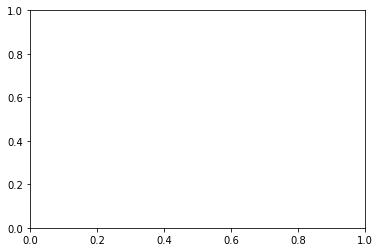

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

<Figure size 2592x864 with 0 Axes>

In [12]:
plot_predictions(model, df, train_indices, test_indices, site_codes, title="Predictions after training", save_path="GPR_figures/" + "1823_NO2_monthly_2020" + "/postTraining/")

In [10]:
df = pickle.load(open("1823_NO2_monthly_2020_df.sav", "rb"))
model = pickle.load(open("1823_NO2_monthly_2020_model.sav", "rb"))
train_indices, test_indices = pickle.load(open("1823_NO2_monthly_2020_indices.sav", "rb"))
SCALERS = pickle.load(open("1823_NO2_monthly_2020_scalers.sav", "rb"))
site_codes = df["code"].unique()

In [16]:
df.head()

,code,date,nox,no2,latitude,longitude,t,norm_lat,norm_lon,norm_no2
0,BG1,2020-09-01,28.481455,18.739817,51.563752,0.177891,0,1.075617,2.027039,-0.842800
7473,RB7,2020-09-01,71.866019,30.236531,51.569484,0.082907,0,1.171141,1.327896,-0.146722
1489,CR7,2020-09-01,73.649117,35.895752,51.362231,-0.117605,0,-2.282563,-0.148008,0.195920
8684,TH4,2020-09-01,123.022765,53.081434,51.515046,-0.008418,0,0.263977,0.655675,1.236441
1646,CT3,2020-09-01,47.945373,31.527763,51.513847,-0.077766,0,0.243996,0.145233,-0.068544


In [29]:
a = df.groupby(by=["code"])

In [30]:
a.head()

,code,date,nox,no2,latitude,longitude,t,norm_lat,norm_lon,norm_no2
0,BG1,2020-09-01,28.481455,18.739817,51.563752,0.177891,0,1.075617,2.027039,-0.842800
7473,RB7,2020-09-01,71.866019,30.236531,51.569484,0.082907,0,1.171141,1.327896,-0.146722
1489,CR7,2020-09-01,73.649117,35.895752,51.362231,-0.117605,0,-2.282563,-0.148008,0.195920
8684,TH4,2020-09-01,123.022765,53.081434,51.515046,-0.008418,0,0.263977,0.655675,1.236441
1646,CT3,2020-09-01,47.945373,31.527763,51.513847,-0.077766,0,0.243996,0.145233,-0.068544
...,...,...,...,...,...,...,...,...,...,...
8836,TL6,2020-12-06,37.858325,29.150973,51.503858,0.020574,96,0.077535,0.869083,-0.212448
8837,TL6,2020-12-07,72.981482,38.406185,51.503858,0.020574,97,0.077535,0.869083,0.347916
8809,TL4,2020-12-07,163.910713,62.723907,51.495057,0.004107,97,-0.069126,0.747875,1.820252
8838,TL6,2020-12-08,111.533034,44.887895,51.503858,0.020574,98,0.077535,0.869083,0.740356


In [13]:
time_range = (datetime(2020, 9, 1), datetime(2020, 12, 31))

In [14]:
print(time_range)

(datetime.datetime(2020, 9, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))
